# Environment Setup

In [94]:
from snowflake.snowpark.session import Session
from snowflake.snowpark.version import VERSION
import snowflake.snowpark as snp
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
import snowflake.snowpark.window as W

import pandas as pd
import json
import seaborn as sns

from snowflake.ml.modeling.lightgbm import LGBMClassifier
from snowflake.ml.modeling.metrics import *

## Create Snowpark Session

In [95]:
# Make a Snowpark Connection
# Edit the connection.json before creating the session object below
# Create Snowflake Session object

connection_parameters = json.load(open('connection.json'))
session = Session.builder.configs(connection_parameters).create()
# require specific numpy version for LGBM
session.custom_package_usage_config = {"enabled": True}
session.add_packages(["numpy==1.26.3"])

snowflake_environment = session.sql('SELECT current_user(), current_version()').collect()
snowpark_version = VERSION

# Current Environment Details
print('\nConnection Established with the following parameters:')
print('User                        : {}'.format(snowflake_environment[0][0]))
print('Role                        : {}'.format(session.get_current_role()))
print('Database                    : {}'.format(session.get_current_database()))
print('Schema                      : {}'.format(session.get_current_schema()))
print('Warehouse                   : {}'.format(session.get_current_warehouse()))
print('Snowflake version           : {}'.format(snowflake_environment[0][1]))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0],snowpark_version[1],snowpark_version[2]))


Connection Established with the following parameters:
User                        : JOHN
Role                        : "ACCOUNTADMIN"
Database                    : "SCORED_MODEL"
Schema                      : "SCORED_MODEL"
Warehouse                   : "QUERY_WH"
Snowflake version           : 8.6.2
Snowpark for Python version : 1.11.1


## Feature Engineering

This notebook is based on the worksheet found here (https://www.kaggle.com/code/ambrosm/amex-lightgbm-quickstart), with some modifications. The dataset has multiple values per customer ID, so we will undertake some feature engineering to find the mean, standard deviation, min, max and last values of each customer ID, so we have features and customer ID as a unique key.

In [46]:
#Create Snowpark df from shared data
training_df = session.table('"CC_DEFAULT_TRAINING_DATA"."DATA_SHARING_DEMO"."CC_DEFAULT_TRAINING_DATA"')

In [47]:
# Check number of rows (5,531,451 rows)
training_df.count()

5531451

In [48]:
# Check first 5 rows
training_df.show(5)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

For the next section, we are going to perform feature engineering create three groups of features:
- Selected features averaged over all statements of a customer
- The minimum or maximum of selected features over all statements of a customer
- Selected features taken from the last statement of a customer

In [49]:
# The following cells create the average numerical values for selected features per customer
features_avg = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_8', 'B_9', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', 'B_28', 'B_29', 'B_30', 'B_32', 'B_33', 'B_37', 'B_38', 'B_39', 'B_40', 'B_41', 'B_42', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_50', 'D_51', 'D_53', 'D_54', 'D_55', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_65', 'D_66', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_74', 'D_75', 'D_76', 'D_77', 'D_78', 'D_80', 'D_82', 'D_84', 'D_86', 'D_91', 'D_92', 'D_94', 'D_96', 'D_103', 'D_104', 'D_108', 'D_112', 'D_113', 'D_114', 'D_115', 'D_117', 'D_118', 'D_119', 'D_120', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_126', 'D_128', 'D_129', 'D_131', 'D_132', 'D_133', 'D_134', 'D_135', 'D_136', 'D_140', 'D_141', 'D_142', 'D_144', 'D_145', 'P_2', 'P_3', 'P_4', 'R_1', 'R_2', 'R_3', 'R_7', 'R_8', 'R_9', 'R_10', 'R_11', 'R_14', 'R_15', 'R_16', 'R_17', 'R_20', 'R_21', 'R_22', 'R_24', 'R_26', 'R_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_9', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_18', 'S_22', 'S_23', 'S_25', 'S_26']

In [50]:
feat = [F.col(c) for c in features_avg]

In [51]:
exprs = {x: "avg" for x in features_avg}

In [52]:
df_avg = (training_df
          .groupBy('"customer_ID"')
          .agg(exprs)
          .rename({F.col(f"AVG({f})"): f"{f}_avg" for f in features_avg})
         )

In [53]:
df_avg.count()

458913

In [54]:
# The following cells create the minimum numerical values for selected features per customer
features_min = ['B_2', 'B_4', 'B_5', 'B_9', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_19', 'B_20', 'B_28', 'B_29', 'B_33', 'B_36', 'B_42', 'D_39', 'D_41', 'D_42', 'D_45', 'D_46', 'D_48', 'D_50', 'D_51', 'D_53', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_62', 'D_70', 'D_71', 'D_74', 'D_75', 'D_78', 'D_83', 'D_102', 'D_112', 'D_113', 'D_115', 'D_118', 'D_119', 'D_121', 'D_122', 'D_128', 'D_132', 'D_140', 'D_141', 'D_144', 'D_145', 'P_2', 'P_3', 'R_1', 'R_27', 'S_3', 'S_5', 'S_7', 'S_9', 'S_11', 'S_12', 'S_23', 'S_25']

In [55]:
exprs_min = {x: "min" for x in features_min}

In [56]:
df_min = (training_df
          .groupBy('"customer_ID"')
          .agg(exprs_min)
          .rename({F.col(f"MIN({f})"): f"{f}_min" for f in features_min})
         )

In [57]:
df_min.count()

458913

In [58]:
# The following cells create the maximum numerical values for selected features per customer
features_max = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9', 'B_10', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_21', 'B_23', 'B_24', 'B_25', 'B_29', 'B_30', 'B_33', 'B_37', 'B_38', 'B_39', 'B_40', 'B_42', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_52', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_63', 'D_64', 'D_65', 'D_70', 'D_71', 'D_72', 'D_73', 'D_74', 'D_76', 'D_77', 'D_78', 'D_80', 'D_82', 'D_84', 'D_91', 'D_102', 'D_105', 'D_107', 'D_110', 'D_111', 'D_112', 'D_115', 'D_116', 'D_117', 'D_118', 'D_119', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_126', 'D_128', 'D_131', 'D_132', 'D_133', 'D_134', 'D_135', 'D_136', 'D_138', 'D_140', 'D_141', 'D_142', 'D_144', 'D_145', 'P_2', 'P_3', 'P_4', 'R_1', 'R_3', 'R_5', 'R_6', 'R_7', 'R_8', 'R_10', 'R_11', 'R_14', 'R_17', 'R_20', 'R_26', 'R_27', 'S_3', 'S_5', 'S_7', 'S_8', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27']

In [59]:
exprs_max = {x: "max" for x in features_max}

In [60]:
df_max = (training_df
          .groupBy('"customer_ID"')
          .agg(exprs_max)
          .rename({F.col(f"MAX({f})"): f"{f}_max" for f in features_max})
         )

In [61]:
df_max.count()

458913

In [62]:
# The following cells create the last numerical values for selected features per customer, with S_2 being the date field.
features_last = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', 'B_26', 'B_28', 'B_29', 'B_30', 'B_32', 'B_33', 'B_36', 'B_37', 'B_38', 'B_39', 'B_40', 'B_41', 'B_42', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_51', 'D_52', 'D_53', 'D_54', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_63', 'D_64', 'D_65', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_75', 'D_76', 'D_77', 'D_78', 'D_79', 'D_80', 'D_81', 'D_82', 'D_83', 'D_86', 'D_91', 'D_96', 'D_105', 'D_106', 'D_112', 'D_114', 'D_119', 'D_120', 'D_121', 'D_122', 'D_124', 'D_125', 'D_126', 'D_127', 'D_130', 'D_131', 'D_132', 'D_133', 'D_134', 'D_138', 'D_140', 'D_141', 'D_142', 'D_145', 'P_2', 'P_3', 'P_4', 'R_1', 'R_2', 'R_3', 'R_4', 'R_5', 'R_6', 'R_7', 'R_8', 'R_9', 'R_10', 'R_11', 'R_12', 'R_13', 'R_14', 'R_15', 'R_19', 'R_20', 'R_26', 'R_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_9', 'S_11', 'S_12', 'S_13', 'S_16', 'S_19', 'S_20', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27', '"customer_ID"', '"target"']

In [63]:
w = snp.Window.partition_by('"customer_ID"').order_by(F.col('S_2').desc())

In [64]:
df_last = training_df.withColumn("rn", F.row_number().over(w)).filter("rn = 1").select(features_last)

In [65]:
df_last.count()

458913

In [66]:
# Now we join these dataframes on customer ID
feature_df = df_min.natural_join(df_avg)

In [67]:
feature_df = feature_df.natural_join(df_max)

In [68]:
feature_df = feature_df.natural_join(df_last)

In [69]:
feature_df.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [70]:
feature_cols = feature_df.columns
feature_cols.remove('"target"')
feature_cols.remove('"customer_ID"')
target_col = '"target"'

In [71]:
for col_name in feature_cols:
    feature_df = feature_df.withColumn(col_name, F.col(col_name).cast(T.FloatType()))

In [72]:
feature_cols

['B_2_MIN',
 'B_4_MIN',
 'B_5_MIN',
 'B_9_MIN',
 'B_13_MIN',
 'B_14_MIN',
 'B_15_MIN',
 'B_16_MIN',
 'B_17_MIN',
 'B_19_MIN',
 'B_20_MIN',
 'B_28_MIN',
 'B_29_MIN',
 'B_33_MIN',
 'B_36_MIN',
 'B_42_MIN',
 'D_39_MIN',
 'D_41_MIN',
 'D_42_MIN',
 'D_45_MIN',
 'D_46_MIN',
 'D_48_MIN',
 'D_50_MIN',
 'D_51_MIN',
 'D_53_MIN',
 'D_55_MIN',
 'D_56_MIN',
 'D_58_MIN',
 'D_59_MIN',
 'D_60_MIN',
 'D_62_MIN',
 'D_70_MIN',
 'D_71_MIN',
 'D_74_MIN',
 'D_75_MIN',
 'D_78_MIN',
 'D_83_MIN',
 'D_102_MIN',
 'D_112_MIN',
 'D_113_MIN',
 'D_115_MIN',
 'D_118_MIN',
 'D_119_MIN',
 'D_121_MIN',
 'D_122_MIN',
 'D_128_MIN',
 'D_132_MIN',
 'D_140_MIN',
 'D_141_MIN',
 'D_144_MIN',
 'D_145_MIN',
 'P_2_MIN',
 'P_3_MIN',
 'R_1_MIN',
 'R_27_MIN',
 'S_3_MIN',
 'S_5_MIN',
 'S_7_MIN',
 'S_9_MIN',
 'S_11_MIN',
 'S_12_MIN',
 'S_23_MIN',
 'S_25_MIN',
 'B_1_AVG',
 'B_2_AVG',
 'B_3_AVG',
 'B_4_AVG',
 'B_5_AVG',
 'B_6_AVG',
 'B_8_AVG',
 'B_9_AVG',
 'B_10_AVG',
 'B_11_AVG',
 'B_12_AVG',
 'B_13_AVG',
 'B_14_AVG',
 'B_15_AVG',
 'B_

In [33]:
session.sql("USE DATABASE SCORED_MODEL").collect()

[Row(status='Statement executed successfully.')]

In [34]:
session.sql("USE SCHEMA SCORED_MODEL").collect()

[Row(status='Statement executed successfully.')]

In [35]:
session.sql("USE WAREHOUSE TRAINING_WH").collect()

[Row(status='Statement executed successfully.')]

Next we will perform imputation over the entire dataset. It will take 10 mins to run to impute missing values for all the columns in the dataset. We will leverage the Snowflake ML Modeling functions to achieve this

In [36]:
from snowflake.ml.modeling.impute import SimpleImputer
# Imputation of Numeric Cols (maybe use larger WH)
my_imputer = SimpleImputer(input_cols= feature_cols,
                           output_cols= feature_cols,
                           strategy='most_frequent')
my_imputer.fit(feature_df)

In [37]:
feature_df = my_imputer.transform(feature_df)

In [38]:
# Split the data into train and test sets
train_df, test_df = feature_df.random_split(weights=[0.9, 0.1], seed=0)

In [39]:
print((feature_df.count(), len(feature_df.columns)))
print((train_df.count(), len(train_df.columns)))
print((test_df.count(), len(test_df.columns)))

(458913, 471)
(413088, 471)
(45825, 471)


The cell below trains the model with the Snowpark ML LGBM Classifier. We call the .fit function over the train_df we just created above

In [40]:
lgbmodel = LGBMClassifier(
    input_cols=feature_cols, 
    label_cols=target_col, 
    output_cols='PREDICTION'
    )
lgbmodel.fit(train_df)

In [41]:
scored_df = lgbmodel.predict(test_df)

Acccuracy: 0.901735
Precision: 0.8105819218514171


DataFrame.flatten() is deprecated since 0.7.0. Use `DataFrame.join_table_function()` instead.


Recall: 0.8116027201746285
F1: 0.8110919998321937


<Axes: >

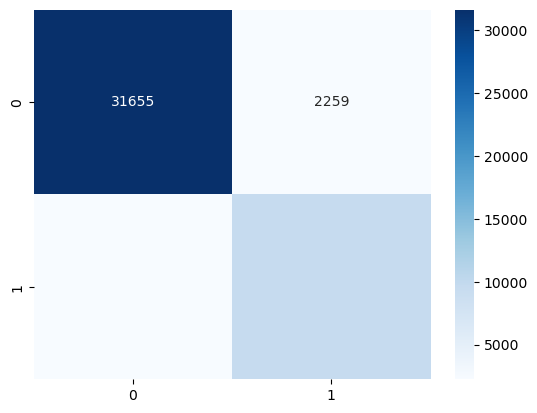

In [42]:
# Get metrics on the scored model
print('Acccuracy:', accuracy_score(df=scored_df, y_true_col_names='"target"', y_pred_col_names='PREDICTION'))
print('Precision:', precision_score(df=scored_df, y_true_col_names='"target"', y_pred_col_names='PREDICTION'))
print('Recall:', recall_score(df=scored_df, y_true_col_names='"target"', y_pred_col_names='PREDICTION'))
print('F1:', f1_score(df=scored_df, y_true_col_names='"target"', y_pred_col_names='PREDICTION'))

# Obtaining and plotting a simple confusion matrix
cf_matrix = confusion_matrix(df=scored_df, y_true_col_name='"target"', y_pred_col_name='PREDICTION')

sns.heatmap(cf_matrix, annot=True, fmt='.0f', cmap='Blues')

We are happy with the metrics of the model above, so we can persist the scored trained dataset (if we want to use it later), and proceed to registering the model

## Model Deployment (Vectorized UDF)

In [43]:
# Create a stage for the model if it doesnt exist
session.sql("CREATE STAGE IF NOT EXISTS MODEL_ASSETS").collect()

[Row(status='Stage area MODEL_ASSETS successfully created.')]

In [44]:
# For this method, we convert the model to a local one, so we can stage it and deploy to Snowflake
lgbmodel_local = lgbmodel.to_lightgbm()

In [45]:
import joblib

# Let's save our model first
MODEL_FILE = 'model.joblib'
joblib.dump(lgbmodel_local, MODEL_FILE) # we are just pickling it locally first

# You can also save the pickled object into the stage we created earlier
session.file.put(MODEL_FILE, "@MODEL_ASSETS", overwrite=True)

[PutResult(source='model.joblib', target='model.joblib.gz', source_size=386351, target_size=169744, source_compression='NONE', target_compression='GZIP', status='UPLOADED', message='')]

In [46]:
import cachetools
from snowflake.snowpark.functions import udf
# Cache the model load to optimize inference
@cachetools.cached(cache={})
def load_model(filename):
    import joblib
    import sys
    import os

    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]

    if import_dir:
        with open(os.path.join(import_dir, filename), 'rb') as file:
            m = joblib.load(file)
            return m

# Register the UDF via decorator
@udf(name='batch_predict_cc_default', 
     session=session, 
     replace=True, 
     is_permanent=True, 
     stage_location='@MODEL_ASSETS',
     input_types=[F.FloatType()]*len(feature_cols),
     return_type=F.FloatType(),
     imports=['@MODEL_ASSETS/model.joblib.gz'],
     packages=['pandas','joblib','cachetools','lightgbm', 'numpy', 'scikit-learn'])
def batch_predict_cc_default(test_df: pd.DataFrame) -> pd.Series:
    # Need to name the columns because column names aren't passed in to this function
    test_df.columns = feature_cols
    model = load_model('model.joblib.gz')
    return model.predict(test_df) # This is using the XGBoost library's model.predict(), not Snowpark ML's

In [47]:
# This cell runs the model in a secure python sandbox in Snowflake
from snowflake.snowpark.functions import call_udf
scored_data = test_df.select('"customer_ID"', call_udf("batch_predict_cc_default", [F.col(c) for c in feature_cols]).alias('Prediction'))

In [48]:
# Persist the results to a table
scored_data.write.save_as_table(table_name='UDF_TEST_SCORED', mode='overwrite')

Now we have a UDF deployed in our Snowflake account called "batch_predict_cc_default" that we can use on incoming data.

## Productionize the Model

We have tested the feature engineering pipeline and the model performance, so we will now productionise the scoring of newly incoming data by leveraging Streams and Tasks. The Tasks will contain Stored Procedures which hold the logic for feature engineering and scoring models.

These can be create from Notebooks using Snowpark functions, but for this HOL we will switch back to Snowsight to demonstrate how it can be done from a SQL Worksheet.

Proceed to step 9 and stay in the Zamboni account

In [ ]:
# Going to create a native app as per instructions here
# https://docs.snowflake.com/en/developer-guide/native-apps/tutorials/getting-started-tutorial#create-an-application-package

In [16]:
# Create an Application Package
session.sql("GRANT CREATE APPLICATION PACKAGE ON ACCOUNT TO ROLE ACCOUNTADMIN;").collect()

[Row(status='Statement executed successfully.')]

In [18]:
# Create an Application Package
session.sql("CREATE APPLICATION PACKAGE IF NOT EXISTS credit_card_prediction_package;").collect()

[Row(status='CREDIT_CARD_PREDICTION_PACKAGE already exists, statement succeeded.')]

In [19]:
# Verfiy the Application Package was created
session.sql("SHOW APPLICATION PACKAGES;").collect()

[Row(created_on=datetime.datetime(2024, 2, 13, 21, 27, 54, 965000, tzinfo=<DstTzInfo 'America/Los_Angeles' PST-1 day, 16:00:00 STD>), name='CREDIT_CARD_PREDICTION_PACKAGE', is_default='N', is_current='N', distribution='INTERNAL', owner='ACCOUNTADMIN', comment='', options='', retention_time='1', dropped_on=None)]

In [20]:
# Create Named Stage - set context
session.sql("USE APPLICATION PACKAGE credit_card_prediction_package;").collect()

[Row(status='Statement executed successfully.')]

In [21]:
session.sql("CREATE SCHEMA IF NOT EXISTS stage_content;").collect()

[Row(status='STAGE_CONTENT already exists, statement succeeded.')]

In [22]:
# Create the stage
# Note You must include FILE_FORMAT = (TYPE = 'CSV' FIELD_DELIMITER = '|' SKIP_HEADER = 1); as part of this command. These are not optional.
session.sql("CREATE OR REPLACE STAGE credit_card_prediction_package.stage_content.credit_card_prediction_stage FILE_FORMAT = (TYPE = 'csv' FIELD_DELIMITER = '|' SKIP_HEADER = 1);").collect()

[Row(status='Stage area CREDIT_CARD_PREDICTION_STAGE successfully created.')]

In [23]:
# Upload the model
session.sql("PUT file://model.joblib @credit_card_prediction_package.stage_content.credit_card_prediction_stage/model overwrite=true auto_compress=false;").collect()

[Row(source='model.joblib', target='model.joblib', source_size=386351, target_size=386352, source_compression='NONE', target_compression='NONE', status='UPLOADED', message='')]

In [24]:
# Check it is uploaded
print("\nContents from the Stage : ")
session.sql("LIST @credit_card_prediction_package.stage_content.credit_card_prediction_stage").collect()


Contents from the Stage : 


[Row(name='credit_card_prediction_stage/model/model.joblib', size=386352, md5='a07f1ead43c231373785f567c509664a', last_modified='Wed, 14 Feb 2024 23:13:51 GMT')]

In [ ]:
# Create UDF that references model file https://github.com/snowflakecorp/native-app-predict-house-price/blob/main/python/deploy_app_to_provider_account.py


In [26]:
# Now lets upload the setup.sql file
session.sql("PUT file://scripts/setup.sql @credit_card_prediction_package.stage_content.credit_card_prediction_stage/scripts overwrite=true auto_compress=false;").collect()

[Row(source='setup.sql', target='setup.sql', source_size=506, target_size=512, source_compression='NONE', target_compression='NONE', status='UPLOADED', message='')]

In [27]:
# and the manifest file
session.sql("PUT file://manifest.yml @credit_card_prediction_package.stage_content.credit_card_prediction_stage overwrite=true auto_compress=false;").collect()

[Row(source='manifest.yml', target='manifest.yml', source_size=64, target_size=80, source_compression='NONE', target_compression='NONE', status='UPLOADED', message='')]

In [28]:
# Check it is uploaded
print("\nContents from the Stage : ")
session.sql("LIST @credit_card_prediction_package.stage_content.credit_card_prediction_stage").collect()


Contents from the Stage : 


[Row(name='credit_card_prediction_stage/manifest.yml', size=80, md5='c7a7727fab3488d9da7e8a63e99bcc61', last_modified='Wed, 14 Feb 2024 23:34:20 GMT'),
 Row(name='credit_card_prediction_stage/model/model.joblib', size=386352, md5='a07f1ead43c231373785f567c509664a', last_modified='Wed, 14 Feb 2024 23:13:51 GMT'),
 Row(name='credit_card_prediction_stage/scripts/setup.sql', size=512, md5='859b230e815800acddb583b357938f32', last_modified='Wed, 14 Feb 2024 23:33:35 GMT')]

In [30]:
# Create the Application
session.sql("CREATE APPLICATION credit_card_prediction_app \
              FROM APPLICATION PACKAGE credit_card_prediction_package \
              USING '@credit_card_prediction_package.stage_content.credit_card_prediction_stage';").collect()

[Row(status="Application 'CREDIT_CARD_PREDICTION_APP' created successfully.")]

In [31]:
# Verify the install
session.sql("SHOW APPLICATIONS;").collect()

[Row(created_on=datetime.datetime(2024, 2, 14, 15, 41, 31, 688000, tzinfo=<DstTzInfo 'America/Los_Angeles' PST-1 day, 16:00:00 STD>), name='CREDIT_CARD_PREDICTION_APP', is_default='N', is_current='Y', source_type='APPLICATION PACKAGE', source='CREDIT_CARD_PREDICTION_PACKAGE', owner='ACCOUNTADMIN', comment='', version='UNVERSIONED', label='', patch=0, options='', retention_time='1'),
 Row(created_on=datetime.datetime(2024, 1, 22, 14, 35, 31, 5000, tzinfo=<DstTzInfo 'America/Los_Angeles' PST-1 day, 16:00:00 STD>), name='SNOWFLAKE', is_default='N', is_current='N', source_type='APPLICATION PACKAGE', source='SNOWHOUSE_IMPORT', owner='', comment='', version='0', label='', patch=0, options='', retention_time='0')]

In [32]:
# Test the native app
session.sql("CALL core.test_proc();").collect()

[Row(TEST_PROC='Hello From Snowflake!')]

In [ ]:
# Add access to data to the application
# This is outlined in the documentation here
# Add the following to the manifest file

references:
- consumer_table:
  label: "Credit Card Default Data"
  description: "A table in the consumer account that exists outside the APPLICATION object. This has the features of the Snowbank customers that the application will risk score"
  privileges:
  - SELECT
  object_type: TABLE
  multi_valued: false
  register_callback: config.register_single_reference

# And add this to the setup.sql

CREATE APPLICATION ROLE app_admin;

CREATE OR ALTER VERSIONED SCHEMA config;
GRANT USAGE ON SCHEMA config TO APPLICATION ROLE app_admin;

CREATE PROCEDURE CONFIG.REGISTER_SINGLE_REFERENCE(ref_name STRING, operation STRING, ref_or_alias STRING)
  RETURNS STRING
  LANGUAGE SQL
  AS $$
    BEGIN
      CASE (operation)
        WHEN 'ADD' THEN
          SELECT SYSTEM$SET_REFERENCE(:ref_name, :ref_or_alias);
        WHEN 'REMOVE' THEN
          SELECT SYSTEM$REMOVE_REFERENCE(:ref_name);
        WHEN 'CLEAR' THEN
          SELECT SYSTEM$REMOVE_REFERENCE(:ref_name);
      ELSE
        RETURN 'unknown operation: ' || operation;
      END CASE;
      RETURN NULL;
    END;
  $$;

GRANT USAGE ON PROCEDURE CONFIG.REGISTER_SINGLE_REFERENCE(STRING, STRING, STRING)
  TO APPLICATION ROLE app_admin;

CREATE PROCEDURE CONFIG.CREATE_VIEW_FROM_REFERENCE_RAW()
  RETURNS STRING
  LANGUAGE SQL
  AS $$
   CREATE OR REPLACE VIEW RAW_TABLE AS
    SELECT * FROM reference('RAW_TABLE');
  $$;

GRANT USAGE ON PROCEDURE CONFIG.CREATE_VIEW_FROM_REFERENCE()
  TO APPLICATION ROLE app_admin;

# Add data accessible to app



CREATE VIEW IF NOT EXISTS core.cc_default_data_view
  AS SELECT * FROM reference('consumer_table');

GRANT SELECT ON VIEW code_schema.accounts_view TO APPLICATION ROLE app_public;

# And add the scoring function to the file
Create or replace function app.batch_predict_cc_default(parameters array)
returns string
language python
runtime_version=3.10
imports=('/model/model.joblib')
packages = ('pandas','joblib','cachetools','lightgbm', 'numpy', 'scikit-learn')
handler='batch_predict_cc_default'
as
$$
import sys
import pandas as pd
from joblib import load
import sklearn
from _snowflake import vectorized

@vectorized(input=pd.DataFrame)
def batch_predict_cc_default(test_df: pd.DataFrame) -> pd.Series:

    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]
    
    model_file = import_dir + 'model.joblib'
    model = load(model_file)
            
    test_df.columns = ['B_2_MIN',
 'B_4_MIN',
 'B_5_MIN',
 'B_9_MIN',
 'B_13_MIN',
 'B_14_MIN',
 'B_15_MIN',
 'B_16_MIN',
 'B_17_MIN',
 'B_19_MIN',
 'B_20_MIN',
 'B_28_MIN',
 'B_29_MIN',
 'B_33_MIN',
 'B_36_MIN',
 'B_42_MIN',
 'D_39_MIN',
 'D_41_MIN',
 'D_42_MIN',
 'D_45_MIN',
 'D_46_MIN',
 'D_48_MIN',
 'D_50_MIN',
 'D_51_MIN',
 'D_53_MIN',
 'D_55_MIN',
 'D_56_MIN',
 'D_58_MIN',
 'D_59_MIN',
 'D_60_MIN',
 'D_62_MIN',
 'D_70_MIN',
 'D_71_MIN',
 'D_74_MIN',
 'D_75_MIN',
 'D_78_MIN',
 'D_83_MIN',
 'D_102_MIN',
 'D_112_MIN',
 'D_113_MIN',
 'D_115_MIN',
 'D_118_MIN',
 'D_119_MIN',
 'D_121_MIN',
 'D_122_MIN',
 'D_128_MIN',
 'D_132_MIN',
 'D_140_MIN',
 'D_141_MIN',
 'D_144_MIN',
 'D_145_MIN',
 'P_2_MIN',
 'P_3_MIN',
 'R_1_MIN',
 'R_27_MIN',
 'S_3_MIN',
 'S_5_MIN',
 'S_7_MIN',
 'S_9_MIN',
 'S_11_MIN',
 'S_12_MIN',
 'S_23_MIN',
 'S_25_MIN',
 'B_1_AVG',
 'B_2_AVG',
 'B_3_AVG',
 'B_4_AVG',
 'B_5_AVG',
 'B_6_AVG',
 'B_8_AVG',
 'B_9_AVG',
 'B_10_AVG',
 'B_11_AVG',
 'B_12_AVG',
 'B_13_AVG',
 'B_14_AVG',
 'B_15_AVG',
 'B_16_AVG',
 'B_17_AVG',
 'B_18_AVG',
 'B_19_AVG',
 'B_20_AVG',
 'B_21_AVG',
 'B_22_AVG',
 'B_23_AVG',
 'B_24_AVG',
 'B_25_AVG',
 'B_28_AVG',
 'B_29_AVG',
 'B_30_AVG',
 'B_32_AVG',
 'B_33_AVG',
 'B_37_AVG',
 'B_38_AVG',
 'B_39_AVG',
 'B_40_AVG',
 'B_41_AVG',
 'B_42_AVG',
 'D_39_AVG',
 'D_41_AVG',
 'D_42_AVG',
 'D_43_AVG',
 'D_44_AVG',
 'D_45_AVG',
 'D_46_AVG',
 'D_47_AVG',
 'D_48_AVG',
 'D_50_AVG',
 'D_51_AVG',
 'D_53_AVG',
 'D_54_AVG',
 'D_55_AVG',
 'D_58_AVG',
 'D_59_AVG',
 'D_60_AVG',
 'D_61_AVG',
 'D_62_AVG',
 'D_65_AVG',
 'D_66_AVG',
 'D_69_AVG',
 'D_70_AVG',
 'D_71_AVG',
 'D_72_AVG',
 'D_73_AVG',
 'D_74_AVG',
 'D_75_AVG',
 'D_76_AVG',
 'D_77_AVG',
 'D_78_AVG',
 'D_80_AVG',
 'D_82_AVG',
 'D_84_AVG',
 'D_86_AVG',
 'D_91_AVG',
 'D_92_AVG',
 'D_94_AVG',
 'D_96_AVG',
 'D_103_AVG',
 'D_104_AVG',
 'D_108_AVG',
 'D_112_AVG',
 'D_113_AVG',
 'D_114_AVG',
 'D_115_AVG',
 'D_117_AVG',
 'D_118_AVG',
 'D_119_AVG',
 'D_120_AVG',
 'D_121_AVG',
 'D_122_AVG',
 'D_123_AVG',
 'D_124_AVG',
 'D_125_AVG',
 'D_126_AVG',
 'D_128_AVG',
 'D_129_AVG',
 'D_131_AVG',
 'D_132_AVG',
 'D_133_AVG',
 'D_134_AVG',
 'D_135_AVG',
 'D_136_AVG',
 'D_140_AVG',
 'D_141_AVG',
 'D_142_AVG',
 'D_144_AVG',
 'D_145_AVG',
 'P_2_AVG',
 'P_3_AVG',
 'P_4_AVG',
 'R_1_AVG',
 'R_2_AVG',
 'R_3_AVG',
 'R_7_AVG',
 'R_8_AVG',
 'R_9_AVG',
 'R_10_AVG',
 'R_11_AVG',
 'R_14_AVG',
 'R_15_AVG',
 'R_16_AVG',
 'R_17_AVG',
 'R_20_AVG',
 'R_21_AVG',
 'R_22_AVG',
 'R_24_AVG',
 'R_26_AVG',
 'R_27_AVG',
 'S_3_AVG',
 'S_5_AVG',
 'S_6_AVG',
 'S_7_AVG',
 'S_9_AVG',
 'S_11_AVG',
 'S_12_AVG',
 'S_13_AVG',
 'S_15_AVG',
 'S_16_AVG',
 'S_18_AVG',
 'S_22_AVG',
 'S_23_AVG',
 'S_25_AVG',
 'S_26_AVG',
 'B_1_MAX',
 'B_2_MAX',
 'B_3_MAX',
 'B_4_MAX',
 'B_5_MAX',
 'B_6_MAX',
 'B_7_MAX',
 'B_8_MAX',
 'B_9_MAX',
 'B_10_MAX',
 'B_12_MAX',
 'B_13_MAX',
 'B_14_MAX',
 'B_15_MAX',
 'B_16_MAX',
 'B_17_MAX',
 'B_18_MAX',
 'B_19_MAX',
 'B_21_MAX',
 'B_23_MAX',
 'B_24_MAX',
 'B_25_MAX',
 'B_29_MAX',
 'B_30_MAX',
 'B_33_MAX',
 'B_37_MAX',
 'B_38_MAX',
 'B_39_MAX',
 'B_40_MAX',
 'B_42_MAX',
 'D_39_MAX',
 'D_41_MAX',
 'D_42_MAX',
 'D_43_MAX',
 'D_44_MAX',
 'D_45_MAX',
 'D_46_MAX',
 'D_47_MAX',
 'D_48_MAX',
 'D_49_MAX',
 'D_50_MAX',
 'D_52_MAX',
 'D_55_MAX',
 'D_56_MAX',
 'D_58_MAX',
 'D_59_MAX',
 'D_60_MAX',
 'D_61_MAX',
 'D_63_MAX',
 'D_64_MAX',
 'D_65_MAX',
 'D_70_MAX',
 'D_71_MAX',
 'D_72_MAX',
 'D_73_MAX',
 'D_74_MAX',
 'D_76_MAX',
 'D_77_MAX',
 'D_78_MAX',
 'D_80_MAX',
 'D_82_MAX',
 'D_84_MAX',
 'D_91_MAX',
 'D_102_MAX',
 'D_105_MAX',
 'D_107_MAX',
 'D_110_MAX',
 'D_111_MAX',
 'D_112_MAX',
 'D_115_MAX',
 'D_116_MAX',
 'D_117_MAX',
 'D_118_MAX',
 'D_119_MAX',
 'D_121_MAX',
 'D_122_MAX',
 'D_123_MAX',
 'D_124_MAX',
 'D_125_MAX',
 'D_126_MAX',
 'D_128_MAX',
 'D_131_MAX',
 'D_132_MAX',
 'D_133_MAX',
 'D_134_MAX',
 'D_135_MAX',
 'D_136_MAX',
 'D_138_MAX',
 'D_140_MAX',
 'D_141_MAX',
 'D_142_MAX',
 'D_144_MAX',
 'D_145_MAX',
 'P_2_MAX',
 'P_3_MAX',
 'P_4_MAX',
 'R_1_MAX',
 'R_3_MAX',
 'R_5_MAX',
 'R_6_MAX',
 'R_7_MAX',
 'R_8_MAX',
 'R_10_MAX',
 'R_11_MAX',
 'R_14_MAX',
 'R_17_MAX',
 'R_20_MAX',
 'R_26_MAX',
 'R_27_MAX',
 'S_3_MAX',
 'S_5_MAX',
 'S_7_MAX',
 'S_8_MAX',
 'S_11_MAX',
 'S_12_MAX',
 'S_13_MAX',
 'S_15_MAX',
 'S_16_MAX',
 'S_22_MAX',
 'S_23_MAX',
 'S_24_MAX',
 'S_25_MAX',
 'S_26_MAX',
 'S_27_MAX',
 'B_1',
 'B_2',
 'B_3',
 'B_4',
 'B_5',
 'B_6',
 'B_7',
 'B_8',
 'B_9',
 'B_10',
 'B_11',
 'B_12',
 'B_13',
 'B_14',
 'B_15',
 'B_16',
 'B_17',
 'B_18',
 'B_19',
 'B_20',
 'B_21',
 'B_22',
 'B_23',
 'B_24',
 'B_25',
 'B_26',
 'B_28',
 'B_29',
 'B_30',
 'B_32',
 'B_33',
 'B_36',
 'B_37',
 'B_38',
 'B_39',
 'B_40',
 'B_41',
 'B_42',
 'D_39',
 'D_41',
 'D_42',
 'D_43',
 'D_44',
 'D_45',
 'D_46',
 'D_47',
 'D_48',
 'D_49',
 'D_50',
 'D_51',
 'D_52',
 'D_53',
 'D_54',
 'D_55',
 'D_56',
 'D_58',
 'D_59',
 'D_60',
 'D_61',
 'D_62',
 'D_63',
 'D_64',
 'D_65',
 'D_69',
 'D_70',
 'D_71',
 'D_72',
 'D_73',
 'D_75',
 'D_76',
 'D_77',
 'D_78',
 'D_79',
 'D_80',
 'D_81',
 'D_82',
 'D_83',
 'D_86',
 'D_91',
 'D_96',
 'D_105',
 'D_106',
 'D_112',
 'D_114',
 'D_119',
 'D_120',
 'D_121',
 'D_122',
 'D_124',
 'D_125',
 'D_126',
 'D_127',
 'D_130',
 'D_131',
 'D_132',
 'D_133',
 'D_134',
 'D_138',
 'D_140',
 'D_141',
 'D_142',
 'D_145',
 'P_2',
 'P_3',
 'P_4',
 'R_1',
 'R_2',
 'R_3',
 'R_4',
 'R_5',
 'R_6',
 'R_7',
 'R_8',
 'R_9',
 'R_10',
 'R_11',
 'R_12',
 'R_13',
 'R_14',
 'R_15',
 'R_19',
 'R_20',
 'R_26',
 'R_27',
 'S_3',
 'S_5',
 'S_6',
 'S_7',
 'S_8',
 'S_9',
 'S_11',
 'S_12',
 'S_13',
 'S_16',
 'S_19',
 'S_20',
 'S_22',
 'S_23',
 'S_24',
 'S_25',
 'S_26',
 'S_27']
    model = load_model('model.joblib.gz')
    return model.predict(test_df) # This is using the XGBoost library's model.predict(), not Snowpark ML's
$$;

GRANT USAGE ON FUNCTION app.batch_predict_cc_default(array) TO APPLICATION ROLE app_public;


In [231]:
# Drop application
session.sql("DROP APPLICATION IF EXISTS credit_card_prediction_app;").collect()

[Row(status='CREDIT_CARD_PREDICTION_APP successfully dropped.')]

In [232]:
# Upload new files
session.sql("PUT file://scripts/setup.sql @credit_card_prediction_package.stage_content.credit_card_prediction_stage/scripts overwrite=true auto_compress=false;").collect()
session.sql("PUT file://manifest.yml @credit_card_prediction_package.stage_content.credit_card_prediction_stage overwrite=true auto_compress=false;").collect()

[Row(source='manifest.yml', target='manifest.yml', source_size=1208, target_size=1216, source_compression='NONE', target_compression='NONE', status='UPLOADED', message='')]

In [233]:
# Create the new Application
session.sql("CREATE APPLICATION credit_card_prediction_app \
              FROM APPLICATION PACKAGE credit_card_prediction_package \
              USING '@credit_card_prediction_package.stage_content.credit_card_prediction_stage';").collect()

[Row(status="Application 'CREDIT_CARD_PREDICTION_APP' created successfully.")]

In [234]:
# We can check the references in the application
session.sql("SHOW REFERENCES IN APPLICATION credit_card_prediction_app;").collect()

[Row(name='IMPUTE_TABLE', label='Credit Card Default Impute Data', description='A table in the consumer account that exists outside the APPLICATION object. This has the features of the Snowbank customers that the application will risk score', privileges='SELECT', object_type='TABLE', multi_valued='false', object_name='', schema_name='', database_name='', alias=''),
 Row(name='RAW_TABLE', label='Credit Card Default Raw Data', description='A table in the consumer account that exists outside the APPLICATION object. This has the features of the Snowbank customers that the application will risk score', privileges='SELECT', object_type='TABLE', multi_valued='false', object_name='', schema_name='', database_name='', alias=''),
 Row(name='TARGET_TABLE', label='Credit Card Default Transformed Data', description='A table in the consumer account that exists outside the APPLICATION object. This has the features of the Snowbank customers that the application will risk score', privileges='INSERT, SE

In [235]:
# Now we want to bind the table to this reference
session.sql("CALL credit_card_prediction_app.config.register_single_reference(\
  'RAW_TABLE' , 'ADD', SYSTEM$REFERENCE('TABLE', 'CC_DEFAULT_TRAINING_DATA.DATA_SHARING_DEMO.CC_DEFAULT_UNSCORED_DATA', 'PERSISTENT', 'SELECT'));").collect()

[Row(REGISTER_SINGLE_REFERENCE=None)]

In [236]:
# Now we want to bind the table to this reference
session.sql("CALL credit_card_prediction_app.config.register_single_reference(\
  'TARGET_TABLE' , 'ADD', SYSTEM$REFERENCE('TABLE', 'SCORED_MODEL.SCORED_MODEL.TRANSFORMED_TABLE', 'PERSISTENT', 'SELECT', 'INSERT'));").collect()

[Row(REGISTER_SINGLE_REFERENCE=None)]

In [237]:
# Now we want to bind the table to this reference
session.sql("CALL credit_card_prediction_app.config.register_single_reference(\
  'IMPUTE_TABLE' , 'ADD', SYSTEM$REFERENCE('TABLE', 'CC_DEFAULT_TRAINING_DATA.DATA_SHARING_DEMO.CC_DEFAULT_UNSCORED_DATA', 'PERSISTENT', 'SELECT'));").collect()

[Row(REGISTER_SINGLE_REFERENCE=None)]

In [238]:
# We can check the references in the application
session.sql("SHOW REFERENCES IN APPLICATION credit_card_prediction_app;").collect()

[Row(name='IMPUTE_TABLE', label='Credit Card Default Impute Data', description='A table in the consumer account that exists outside the APPLICATION object. This has the features of the Snowbank customers that the application will risk score', privileges='SELECT', object_type='TABLE', multi_valued='false', object_name='CC_DEFAULT_UNSCORED_DATA', schema_name='DATA_SHARING_DEMO', database_name='CC_DEFAULT_TRAINING_DATA', alias='9cd5a7fd-e965-4f4c-be3e-c4ce1e048fdc'),
 Row(name='RAW_TABLE', label='Credit Card Default Raw Data', description='A table in the consumer account that exists outside the APPLICATION object. This has the features of the Snowbank customers that the application will risk score', privileges='SELECT', object_type='TABLE', multi_valued='false', object_name='CC_DEFAULT_UNSCORED_DATA', schema_name='DATA_SHARING_DEMO', database_name='CC_DEFAULT_TRAINING_DATA', alias='b6cd2691-f2ff-48e1-88cb-9c9615003e57'),
 Row(name='TARGET_TABLE', label='Credit Card Default Transformed Dat

In [239]:
# Test the native app
session.sql("CALL CONFIG.CREATE_TABLE_FROM_REFERENCE_RAW();").collect()

[Row(CREATE_TABLE_FROM_REFERENCE_RAW=None)]

In [240]:
# Test the native app
session.sql("CALL CORE.cc_profile_processing('CONFIG.RAW_TABLE', 'CONFIG.TRANSFORMED_TABLE', 'CONFIG.RAW_TABLE');").collect()

[Row(CC_PROFILE_PROCESSING='Success')]

In [241]:
# Test the native app - problem with vectorized udf
session.sql("CALL CORE.cc_batch_processing('CONFIG.TRANSFORMED_TABLE', 'CONFIG.SCORED_TABLE');").collect()

[Row(CC_BATCH_PROCESSING='Success')]

In [ ]:
# How do we get the SPROC to access the data?
# Where is the data? How do I see it?